# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [ ]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [ ]:
!pip -q install 'tensorflow-privacy==0.5.2'
#!pip -q install git+https://github.com/tensorflow/privacy #TODO fix this

##### Import libraries

In [ ]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

#import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [ ]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [256, 256, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [ ]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [ ]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [ ]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=TEST_SPLIT, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SPLIT, random_state=random_state)

In [ ]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 8136, Val: 904, Test: 1356


In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4883, 'COVID-19': 3253}
val set:  {'normal': 541, 'COVID-19': 363}
test set:   {'normal': 817, 'COVID-19': 539}


###### Create tensors

In [ ]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [ ]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [ ]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [ ]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [ ]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [ ]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [ ]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [ ]:
# seperate train labels and images for attacks
x_train_attack = prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=1,
                                 augment=False,
                                 cache=False)

y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(x_train_attack):
    y_train_attack.append(y)

# seperate test labels and images for attacks
x_test_attack = prepare_dataset(test_ds,
                                pre=True,
                                shuffle=False,
                                repeat=False,
                                batch=1,
                                augment=False,
                                cache=False)

y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(x_test_attack):
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

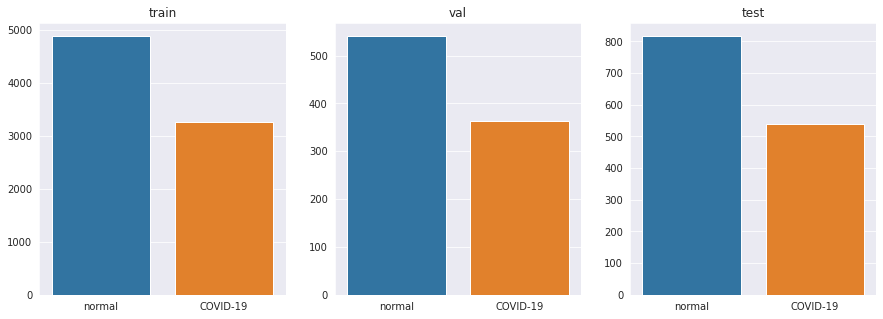

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


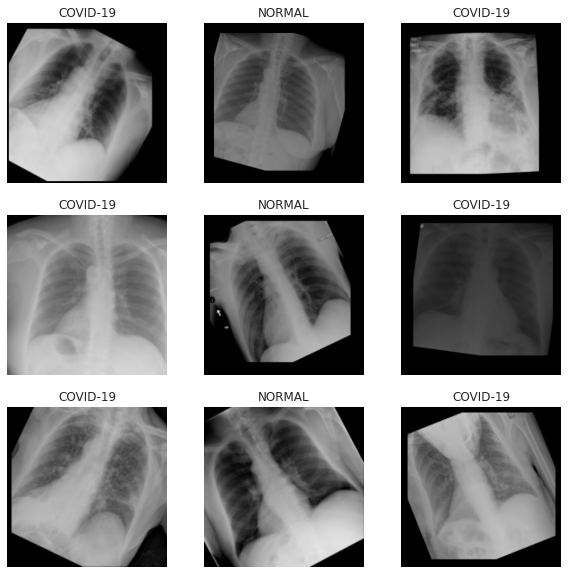

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## ResNet18V2
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('relu', name=name + '_preact_relu')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_relu')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('relu', name='post_relu')(x)
    # Create model.
    model = tf.keras.models.Model(input, x, name=model_name)
    return model

def ResNet50V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 3, name='conv2') # original: 64
        x = resnet_stack(x, 32, 4, name='conv3')
        x = resnet_stack(x, 64, 6, name='conv4')
        x = resnet_stack(x, 128, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet50v2')

In [ ]:
def resnet50_hand_builder():
    # ResNet18V2 without head
    resnet50 = ResNet50V2(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet50, # add resnet50 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet50V2')
    
    return model

In [ ]:
resnet50_hand = resnet50_hand_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50_hand.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
resnet50_hand.summary()

Model: "ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 8, 8, 512)         1506304   
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 1,506,817
Trainable params: 1,495,361
Non-trainable params: 11,456
_________________________________________________________________


### Training

In [ ]:
history_resnet50_hand = resnet50_hand.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
254/254 [==============================] - 141s 433ms/step - loss: 0.5665 - accuracy: 0.7167 - precision: 0.6274 - recall: 0.7003 - val_loss: 2.2170 - val_accuracy: 0.4219 - val_precision: 0.4097 - val_recall: 0.9861
Epoch 2/20
254/254 [==============================] - 98s 388ms/step - loss: 0.4584 - accuracy: 0.7762 - precision: 0.6916 - recall: 0.8020 - val_loss: 13.6728 - val_accuracy: 0.3839 - val_precision: 0.3872 - val_recall: 0.9086
Epoch 3/20
254/254 [==============================] - 98s 388ms/step - loss: 0.4161 - accuracy: 0.8001 - precision: 0.7194 - recall: 0.8264 - val_loss: 37.2828 - val_accuracy: 0.4007 - val_precision: 0.4005 - val_recall: 0.9806
Epoch 4/20
254/254 [==============================] - 98s 387ms/step - loss: 0.3484 - accuracy: 0.8374 - precision: 0.7617 - recall: 0.8660 - val_loss: 0.2868 - val_accuracy: 0.8

### Evaluation

###### Visualize performance

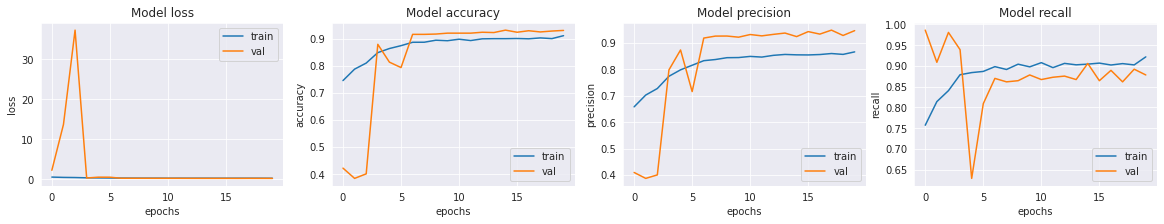

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet50_hand.history[met])
    ax[i].plot(history_resnet50_hand.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50_hand.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 71ms/step - loss: 0.1791 - accuracy: 0.9299 - precision: 0.9405 - recall: 0.8794
Loss of the model is -  0.17911097407341003
Accuracy of the model is -  92.99409985542297 %
Precision of the model is -  0.9404761791229248
Recall of the model is -  0.8794063329696655


## Evaluation

In [ ]:
models = [
    resnet50_hand,
]

### Model Analysis

In [ ]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating ResNet50V2 ...
43/43 [==============================] - 1s 33ms/step - loss: 0.1791 - accuracy: 0.9299 - precision: 0.9405 - recall: 0.8794




### Privacy Analysis

#### Compute epsilon

In [ ]:
# no noise added here
NOISE_MULTIPLIER = 0.0

In [ ]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [ ]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = inf


#### Membership Inference Attack

In [ ]:
# run membership inference attack
def run_mia(model, x_train_attack, x_test_attack, y_train_attack, y_test_attack):
    # predict on train
    probs_train = model.predict(x_train_attack)
    # predict on test
    probs_test = model.predict(x_test_attack)

    # only label as output instead of prob
    #probs_train = np.round(logits_train)
    #probs_test = np.round(logits_test)

    # compute losses
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant

    loss_train = np.array([x[0] for x in bc(constant([[y] for y in y_train_attack]), constant(probs_train), from_logits=False).numpy()])
    loss_test = np.array([x[0] for x in bc(constant([[y] for y in y_test_attack]), constant(probs_test), from_logits=False).numpy()])

    # labels
    train_labels = np.array(y_train_attack)
    test_labels = np.array(y_test_attack)

    # prepare attacks
    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = train_labels,
        labels_test = test_labels
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,)

    attack_types = [
        AttackType.THRESHOLD_ATTACK,
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    plt.show()

    # print a user-friendly summary of the attacks
    print(attacks_result.summary(by_slices=False)) #TODO fix low auc sometimes

Membership Inference Attack on ResNet50V2...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


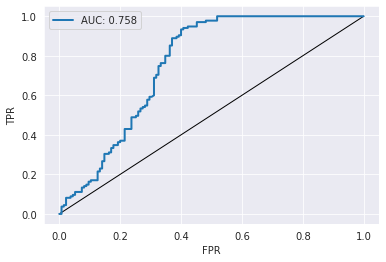

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.76 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.53 on slice CLASS=1




In [ ]:
for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    run_mia(model, x_train_attack, x_test_attack, y_train_attack, y_test_attack)
    print('\n')